In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import sklearn.metrics as met
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from scipy import signal
import itertools
from collections import deque
from collections import Counter


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import TimeSeriesSplit

In [4]:
X_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/X_train.txt")
X_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/X_test.txt")
Y_train = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/y_train.txt")
Y_test = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/y_test.txt")

X = np.vstack((X_train, X_test))
Y = np.hstack((Y_train, Y_test))

feature_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/features.txt",dtype='str')
label_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/activity_labels.txt", dtype='str')
label_names = [l[1] for l in label_names ]
label_names

transition_label_names=np.array(['ACTIVITIES', 'STAND_TO_SIT',
 'SIT_TO_STAND',
 'SIT_TO_LIE',
 'LIE_TO_SIT',
 'STAND_TO_LIE',
 'LIE_TO_STAND'])

activity_label_names=np.array(['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING',
'TRANSITIONS'])

X_transition_train=X[:int(len(X)*0.6)]
X_transition_validation=X[int(len(X)*0.6):int(len(X)*0.8)]
X_transition_test=X[int(len(X)*0.8):]
Y_transition_train=np.where(Y[:int(len(Y)*0.6)] > 6, Y[:int(len(Y)*0.6)], 0)
Y_transition_validation=np.where(Y[int(len(Y)*0.6):int(len(X)*0.8)] > 6, Y[int(len(Y)*0.6):int(len(X)*0.8)], 0)
Y_transition_test=np.where(Y[int(len(Y)*0.8):] > 6, Y[int(len(Y)*0.8):], 0)

X_activities_train=X[:int(len(X)*0.6)]
X_activities_validation=X[int(len(X)*0.6):int(len(X)*0.8)]
X_activities_test=X[int(len(X)*0.8):]
Y_activities_train=np.where(Y[:int(len(Y)*0.6)] < 7, Y[:int(len(Y)*0.6)], 0)
Y_activities_validation=np.where(Y[int(len(Y)*0.6):int(len(X)*0.8)] < 7, Y[int(len(Y)*0.6):int(len(X)*0.8)], 0)
Y_activities_test=np.where(Y[int(len(Y)*0.8):] < 7, Y[int(len(Y)*0.8):], 0)

In [5]:
train_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Train/subject_id_train.txt")
test_uid = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/Test/subject_id_test.txt")
user_ids = np.hstack((train_uid, test_uid))
rand_uid=[np.random.choice(np.unique(user_ids), len(np.unique(user_ids)), replace=False) for _ in range(5)]
rand_uid

[array([ 8.,  9.,  6.,  7., 29., 23., 14., 30.,  3., 18., 12., 15., 11.,
        13., 25., 26.,  5.,  1., 10., 19., 22., 27., 28.,  2., 17.,  4.,
        16., 24., 21., 20.]),
 array([20., 21., 13.,  5., 28., 30., 11., 24., 23., 29., 22., 19.,  7.,
        14., 18.,  1.,  4.,  3., 16., 17., 25.,  2.,  6., 10., 27.,  9.,
        15., 26.,  8., 12.]),
 array([11.,  7., 17., 10.,  8., 12., 29., 13., 28.,  4., 30., 14., 22.,
         2., 25.,  6.,  5., 23., 24., 16., 21.,  3.,  9., 15., 20., 18.,
        19.,  1., 27., 26.]),
 array([ 4., 24.,  2., 14., 26.,  6., 30., 18., 28.,  7., 27., 10.,  1.,
        22., 19.,  9.,  3., 13., 16., 15., 11., 23., 20.,  5., 17.,  8.,
        25., 21., 12., 29.]),
 array([17.,  9., 15., 29.,  4.,  7., 16., 20., 12., 11., 24.,  8., 18.,
        28., 10., 27., 26., 14., 19., 25.,  3., 30.,  5.,  2., 22., 13.,
         6.,  1., 21., 23.])]

In [7]:
def one_hot(y, labels):
    Y_onehot=[]
    for l in y:
        empty_label=np.zeros(len(labels))
        empty_label[labels.index(l)]=1.
        Y_onehot.append(empty_label)
    return(np.vstack(Y_onehot))


In [8]:
def get_metrics(target, output):
        
        pred = np.round(output)
        
        tp = np.sum(((pred + target) == 2).astype(float), axis=0)
        fp = np.sum(((pred - target) == 1).astype(float), axis=0)
        fn = np.sum(((pred - target) == -1).astype(float), axis=0)
        tn = np.sum(((pred + target) == 0).astype(float), axis=0)

        acc = (tp + tn) / (tp + tn + fp + fn)
        try:
            prec = tp / (tp + fp)
        except ZeroDivisionError:
            prec = 0.0
        try:
            rec = tp / (tp + fn)
        except ZeroDivisionError:
            rec = 0.0
        try:
            specificity = tn / (tn + fp)
        except ZeroDivisionError:
            specificity = 0.0


        try:
            f1=2.*((prec*rec)/(prec+rec))
        except ZeroDivisionError:
            f1 = 0.0
        
        acc[acc != acc] = 0.
        prec[prec != prec] = 0.
        rec[rec != rec] = 0.
        specificity[specificity != specificity] = 0.
        f1[f1 != f1] = 0.
        
        balanced_accuracy = (rec + specificity) / 2.
        
        err_rate = np.subtract(1., acc)
        f1_micro, f1_macro, f1_weight, log_ls, roc = [], [], [], [], []
        for idx in range(target.shape[1]):
            y_test=target[:,idx]
            y_pred=pred[:,idx]
            
            f1_micro.append(f1_score(y_test, y_pred, average= 'micro'))
            f1_macro.append(f1_score(y_test, y_pred, average= 'macro'))
            f1_weight.append(f1_score(y_test, y_pred, average= 'weighted'))
            log_ls.append(log_loss(y_test, y_pred, labels=[0., 1.]))
            try:
                roc.append(roc_auc_score(y_test, output[:, idx]))
            except ValueError:
                roc.append(np.nan)
            
        return (balanced_accuracy, acc, err_rate, prec, rec, specificity, f1, tp, fp, fn, tn, np.array(f1_micro), np.array(f1_macro), np.array(f1_weight), np.array(log_ls), np.array(roc))
    

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    dtype = torch.FloatTensor

In [10]:
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1

In [11]:
train_inp, train_out = X_transition_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
val_inp, val_out = X_transition_validation, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
test_inp, test_out = X_transition_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

In [11]:
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.output_size=output_size
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.1).cuda()
        self.linear = nn.Linear(hidden_size*num_directions, output_size)
        self.act = nn.Softmax()
        #self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], self.output_size).cuda()
        #pred = nn.Sigmoid(self.linear(pred)).view(pred.data.shape[0], 12)
        return pred

In [12]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(transition_label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
    with open("timesplit_Transition_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("timesplit_Transition_classification_results_BiGRU_paper_comp_2_conf_matrix.csv", 'a') as f:
        pd.DataFrame(np.hstack((transition_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
        
    plt.subplots(figsize=(20,15))
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=transition_label_names, yticklabels=transition_label_names)
    title="Transition Learning"
    s.set_title(title)
    

In [13]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 7
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.0730, device='cuda:0'))
(100, tensor(1.0429, device='cuda:0'))
(200, tensor(1.0367, device='cuda:0'))
(300, tensor(1.0345, device='cuda:0'))
(400, tensor(1.0336, device='cuda:0'))
(500, tensor(1.0331, device='cuda:0'))
(600, tensor(1.0328, device='cuda:0'))
(700, tensor(1.0327, device='cuda:0'))
(800, tensor(1.0325, device='cuda:0'))
(900, tensor(1.0325, device='cuda:0'))
(1000, tensor(1.0324, device='cuda:0'))
(1100, tensor(1.0323, device='cuda:0'))
(1200, tensor(1.0323, device='cuda:0'))
(1300, tensor(1.0323, device='cuda:0'))
(1400, tensor(1.0322, device='cuda:0'))
(1500, tensor(1.0322, device='cuda:0'))
(1600, tensor(1.0322, device='cuda:0'))
(1700, tensor(1.0322, device='cuda:0'))
(1800, tensor(1.0322, device='cuda:0'))
(1900, tensor(1.0322, device='cuda:0'))
(2000, tensor(1.0322, device='cuda:0'))
(2100, tensor(1.0322, device='cuda:0'))
(2200, tensor(1.0321, device='cuda:0'))
(2300, tensor(1.0321, device='cuda:0'))
(2400, tensor(1.0321, device='cuda:0'))
(2500, tenso

(700, tensor(1.2669, device='cuda:0'))
(800, tensor(1.2665, device='cuda:0'))
(900, tensor(1.2662, device='cuda:0'))
(1000, tensor(1.2660, device='cuda:0'))
(1100, tensor(1.2657, device='cuda:0'))
(1200, tensor(1.2656, device='cuda:0'))
(1300, tensor(1.2654, device='cuda:0'))
(1400, tensor(1.2653, device='cuda:0'))
(1500, tensor(1.2652, device='cuda:0'))
(1600, tensor(1.2651, device='cuda:0'))
(1700, tensor(1.2650, device='cuda:0'))
(1800, tensor(1.2650, device='cuda:0'))
(1900, tensor(1.2649, device='cuda:0'))
(2000, tensor(1.2649, device='cuda:0'))
(2100, tensor(1.2649, device='cuda:0'))
(2200, tensor(1.2648, device='cuda:0'))
(2300, tensor(1.2648, device='cuda:0'))
(2400, tensor(1.2648, device='cuda:0'))
(2500, tensor(1.2648, device='cuda:0'))
(2600, tensor(1.2648, device='cuda:0'))
(2700, tensor(1.2648, device='cuda:0'))
(2800, tensor(1.2647, device='cuda:0'))
(2900, tensor(1.2647, device='cuda:0'))
(3000, tensor(1.2647, device='cuda:0'))
(3100, tensor(1.2647, device='cuda:0'))
(32

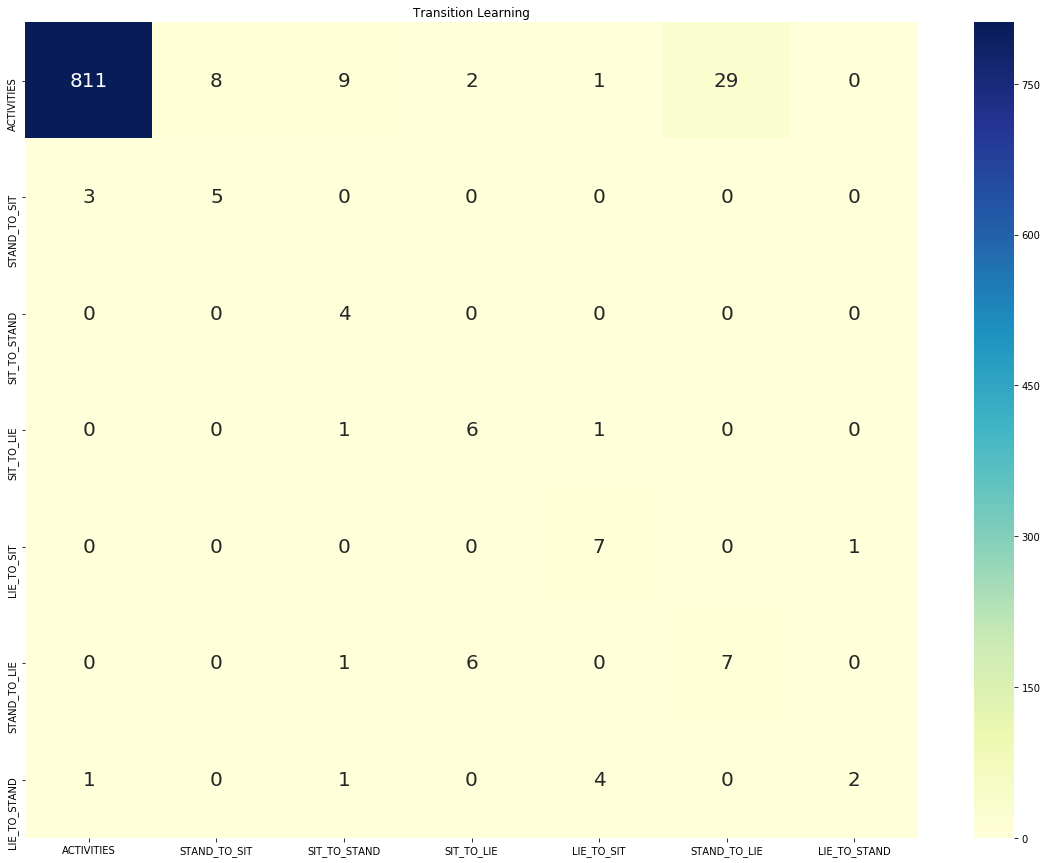

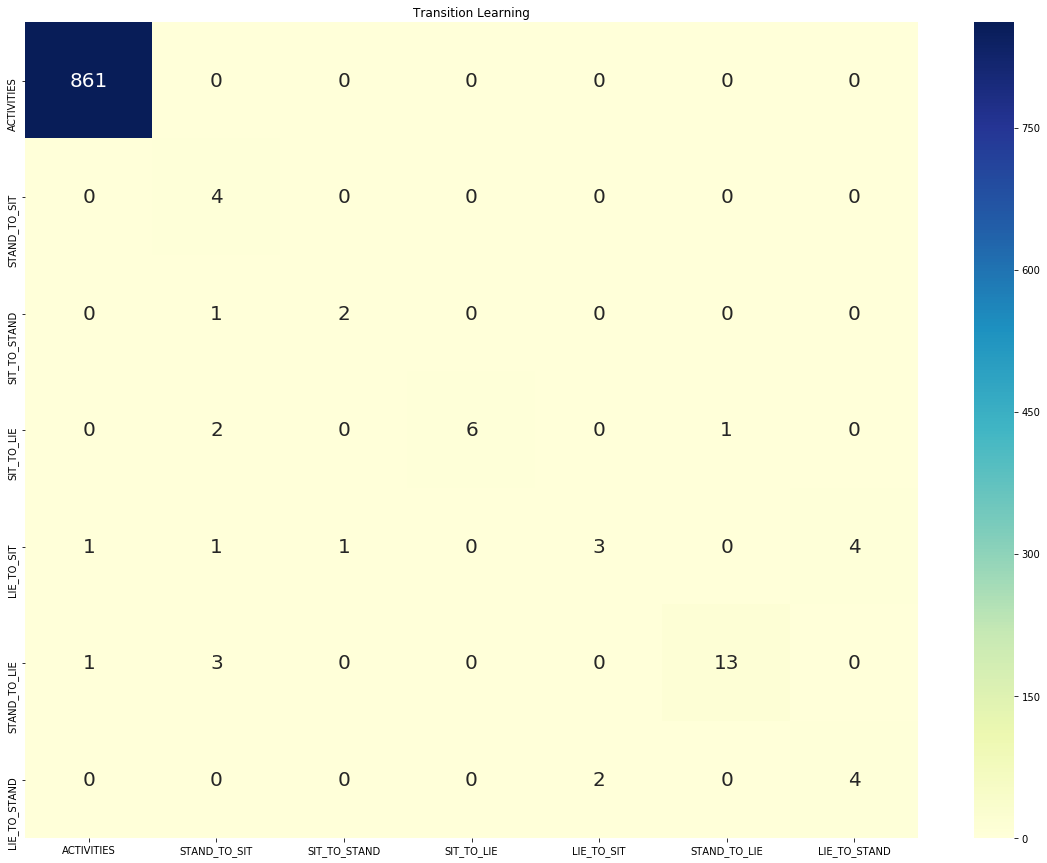

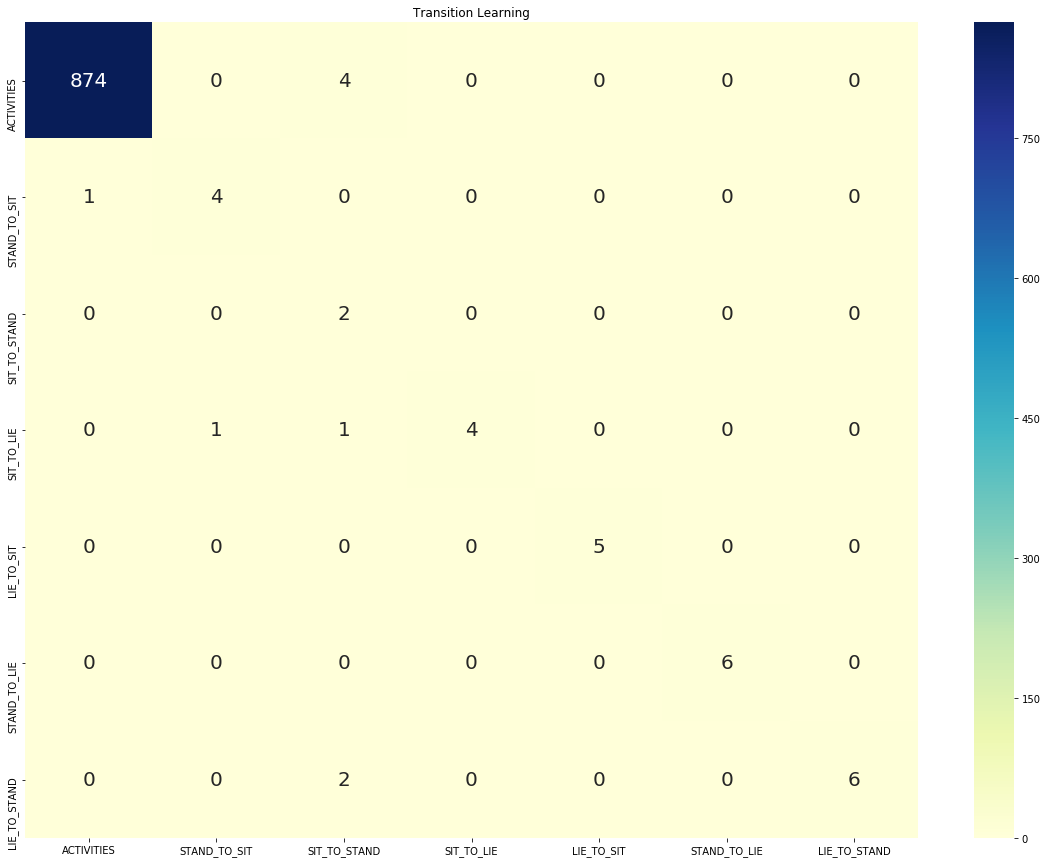

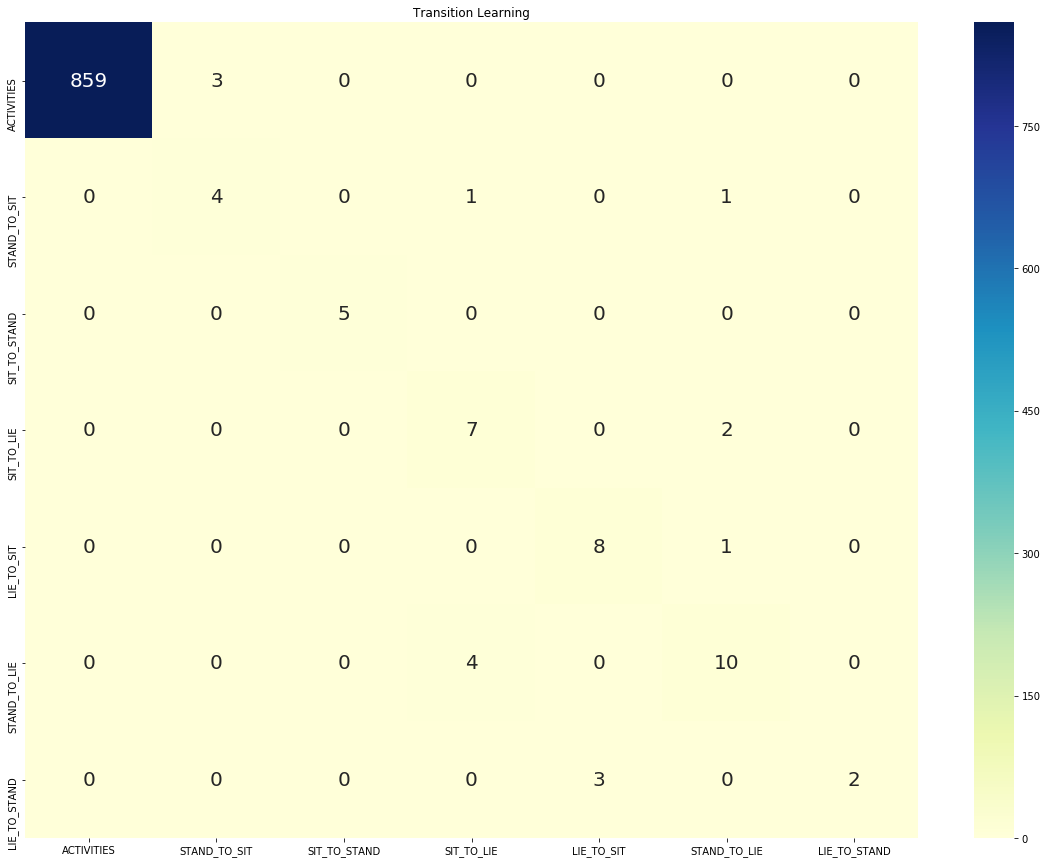

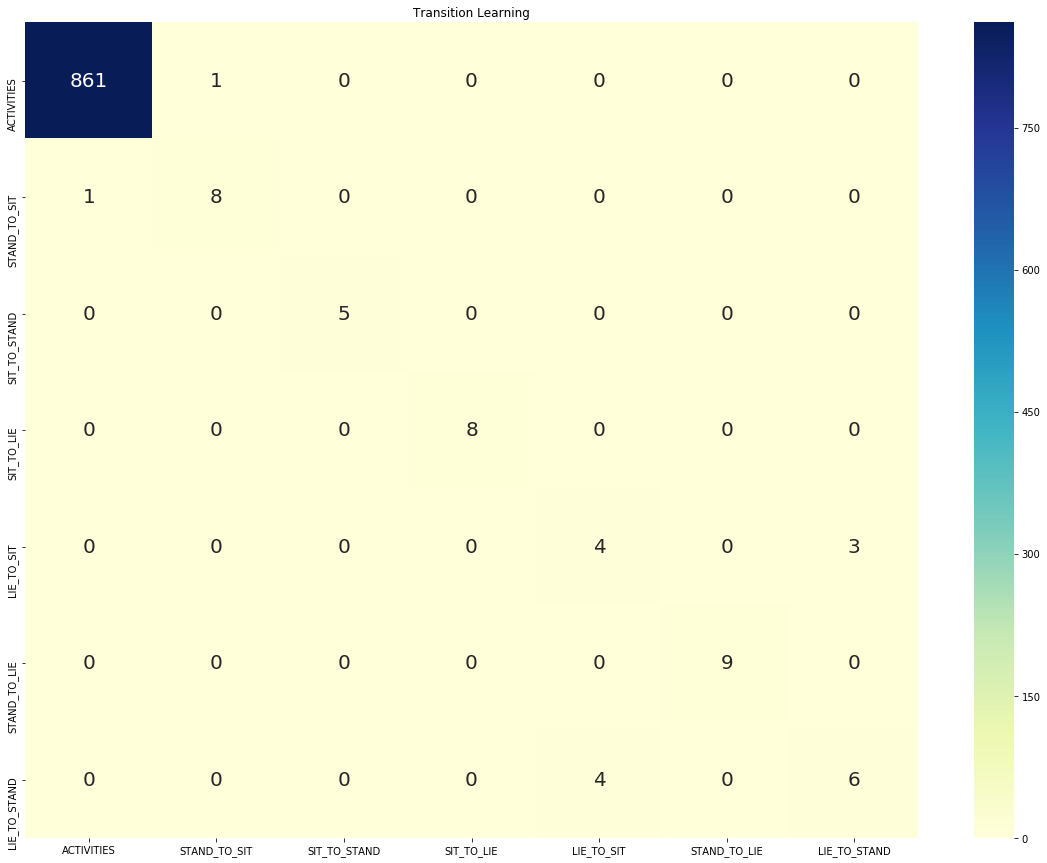

In [18]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index )
    X_train, X_test, X_val = X[train_index], X[test_index[int(len(test_index)*0.5):]], X[test_index[:int(len(test_index)*0.5)]]
    Y_train, Y_test, Y_val = Y[train_index], Y[test_index[int(len(test_index)*0.5):]], Y[test_index[:int(len(test_index)*0.5)]]
    Y_transition_train=np.where(Y_train > 6, Y_train, 0)
    Y_transition_validation=np.where(Y_val > 6, Y_val, 0)
    Y_transition_test=np.where(Y_test > 6, Y_test, 0)
    Y_activities_train=np.where(Y_train < 7, Y_train, 0)
    Y_activities_validation=np.where(Y_val < 7, Y_val, 0)
    Y_activities_test=np.where(Y_test < 7, Y_test, 0)
    train_inp, train_out = X_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
    val_inp, val_out = X_val, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
    test_inp, test_out = X_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])
    
    train_gru(config, train_inp, train_out, val_inp, val_out)

In [14]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 7
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

In [19]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_out.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(activity_label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((activity_label_names, np.vstack(results_metrics)))))
    with open("timesplit_Activity_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("timesplit_Activity_classification_results_BiGRU_paper_comp_2_confusion_matrix.csv", 'a') as f:
        pd.DataFrame(np.hstack((activity_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
             
    plt.subplots(figsize=(20,15))
    sns.set(font_scale = 1.8)
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=activity_label_names, yticklabels=activity_label_names)
    title="Activity Learning"
    s.set_title(title)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.0755, device='cuda:0'))
(100, tensor(0.8696, device='cuda:0'))
(200, tensor(0.8392, device='cuda:0'))
(300, tensor(0.8288, device='cuda:0'))
(400, tensor(0.8232, device='cuda:0'))
(500, tensor(0.8195, device='cuda:0'))
(600, tensor(0.8168, device='cuda:0'))
(700, tensor(0.8148, device='cuda:0'))
(800, tensor(0.8132, device='cuda:0'))
(900, tensor(0.8118, device='cuda:0'))
(1000, tensor(0.8106, device='cuda:0'))
(1100, tensor(0.8096, device='cuda:0'))
(1200, tensor(0.8086, device='cuda:0'))
(1300, tensor(0.8077, device='cuda:0'))
(1400, tensor(0.8069, device='cuda:0'))
(1500, tensor(0.8061, device='cuda:0'))
(1600, tensor(0.8055, device='cuda:0'))
(1700, tensor(0.8049, device='cuda:0'))
(1800, tensor(0.8044, device='cuda:0'))
(1900, tensor(0.8040, device='cuda:0'))
(2000, tensor(0.8036, device='cuda:0'))
(2100, tensor(0.8033, device='cuda:0'))
(2200, tensor(0.8031, device='cuda:0'))
(2300, tensor(0.8029, device='cuda:0'))
(2400, tensor(0.8027, device='cuda:0'))
(2500, tenso

(700, tensor(1.0556, device='cuda:0'))
(800, tensor(1.0540, device='cuda:0'))
(900, tensor(1.0525, device='cuda:0'))
(1000, tensor(1.0511, device='cuda:0'))
(1100, tensor(1.0499, device='cuda:0'))
(1200, tensor(1.0487, device='cuda:0'))
(1300, tensor(1.0475, device='cuda:0'))
(1400, tensor(1.0463, device='cuda:0'))
(1500, tensor(1.0452, device='cuda:0'))
(1600, tensor(1.0442, device='cuda:0'))
(1700, tensor(1.0432, device='cuda:0'))
(1800, tensor(1.0423, device='cuda:0'))
(1900, tensor(1.0414, device='cuda:0'))
(2000, tensor(1.0406, device='cuda:0'))
(2100, tensor(1.0399, device='cuda:0'))
(2200, tensor(1.0392, device='cuda:0'))
(2300, tensor(1.0386, device='cuda:0'))
(2400, tensor(1.0380, device='cuda:0'))
(2500, tensor(1.0375, device='cuda:0'))
(2600, tensor(1.0371, device='cuda:0'))
(2700, tensor(1.0367, device='cuda:0'))
(2800, tensor(1.0363, device='cuda:0'))
(2900, tensor(1.0360, device='cuda:0'))
(3000, tensor(1.0357, device='cuda:0'))
(3100, tensor(1.0354, device='cuda:0'))
(32

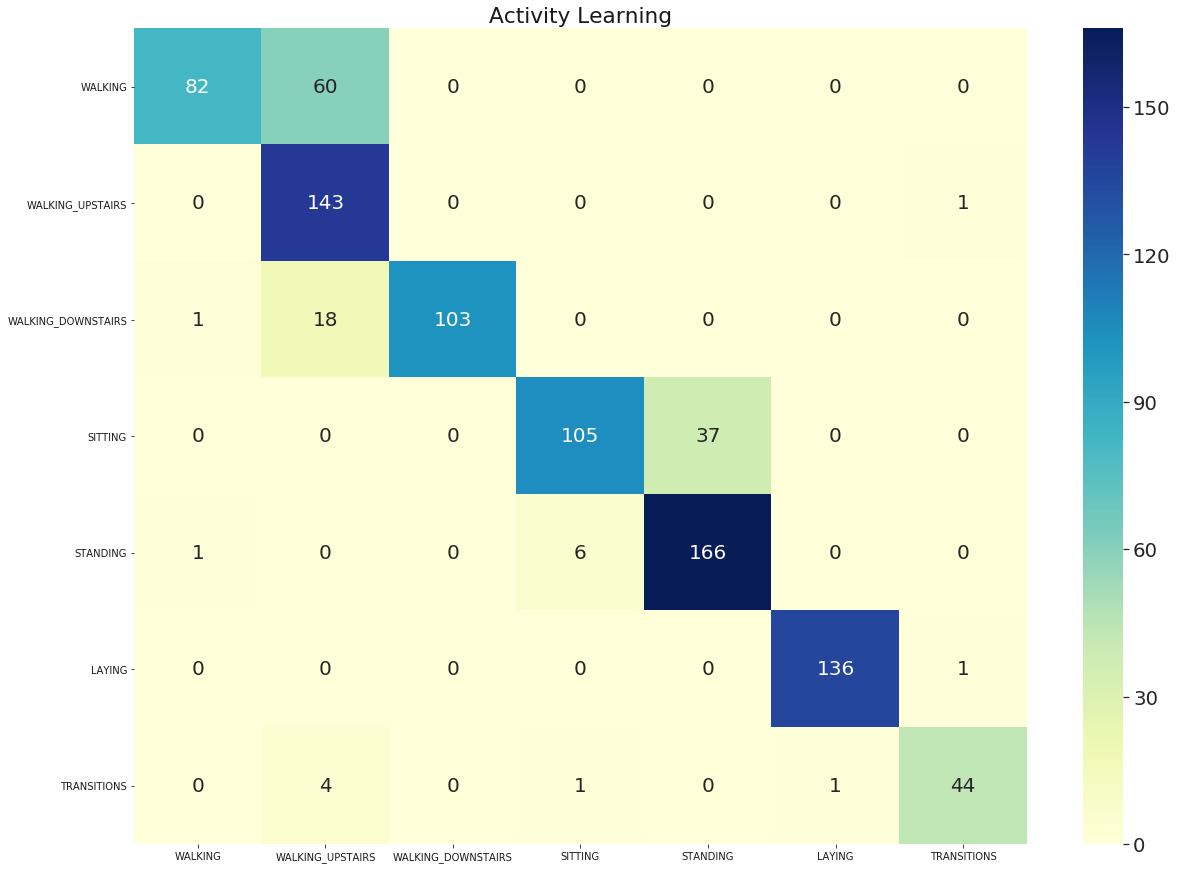

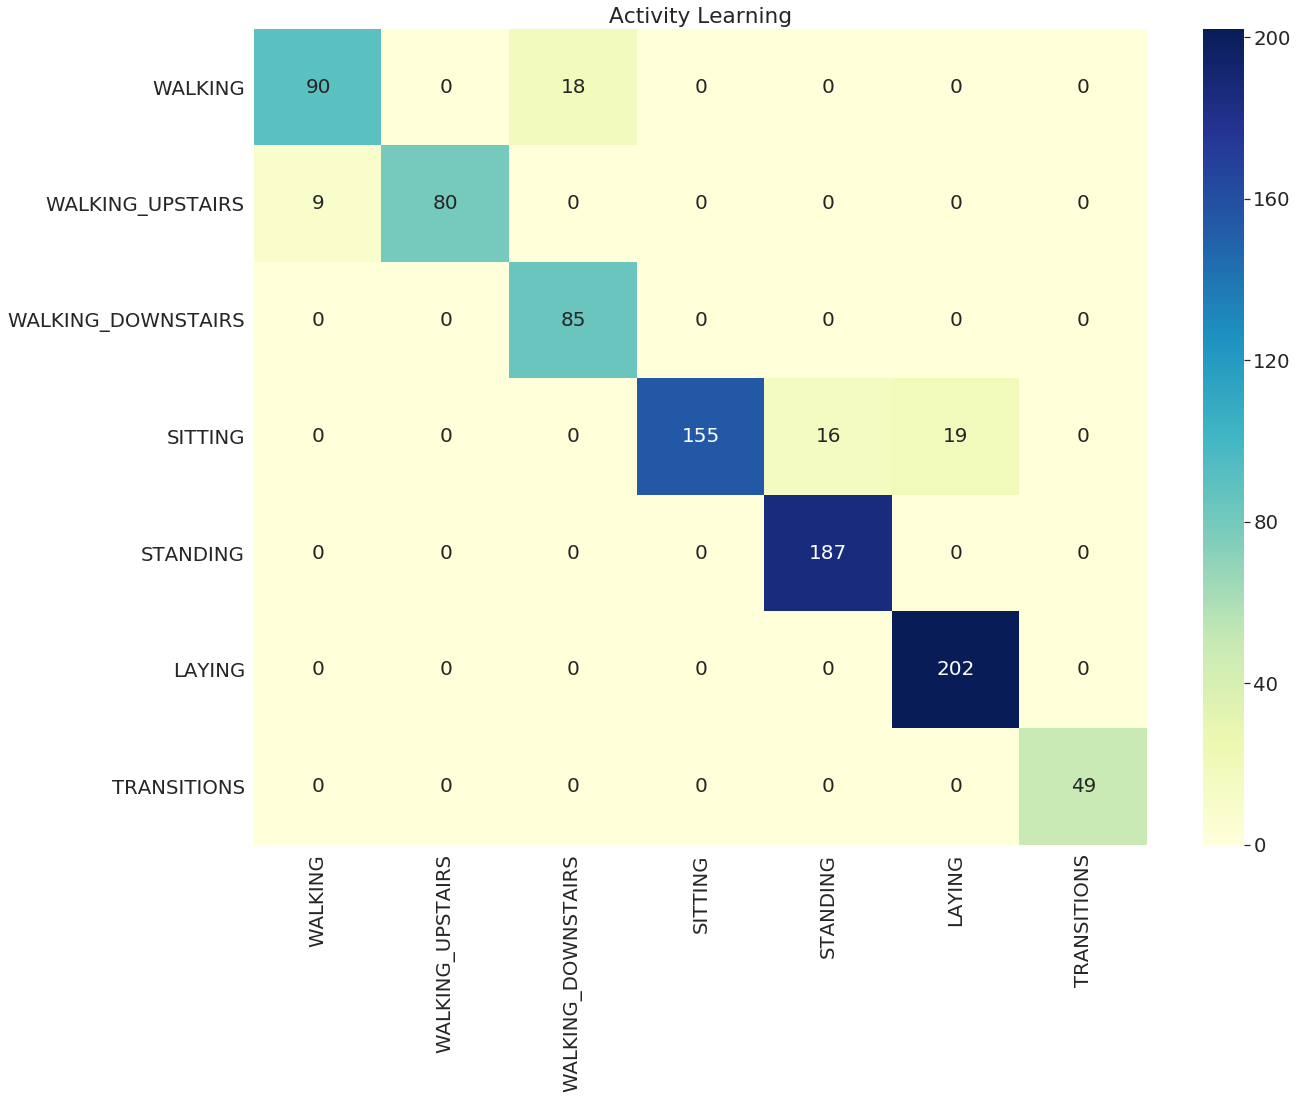

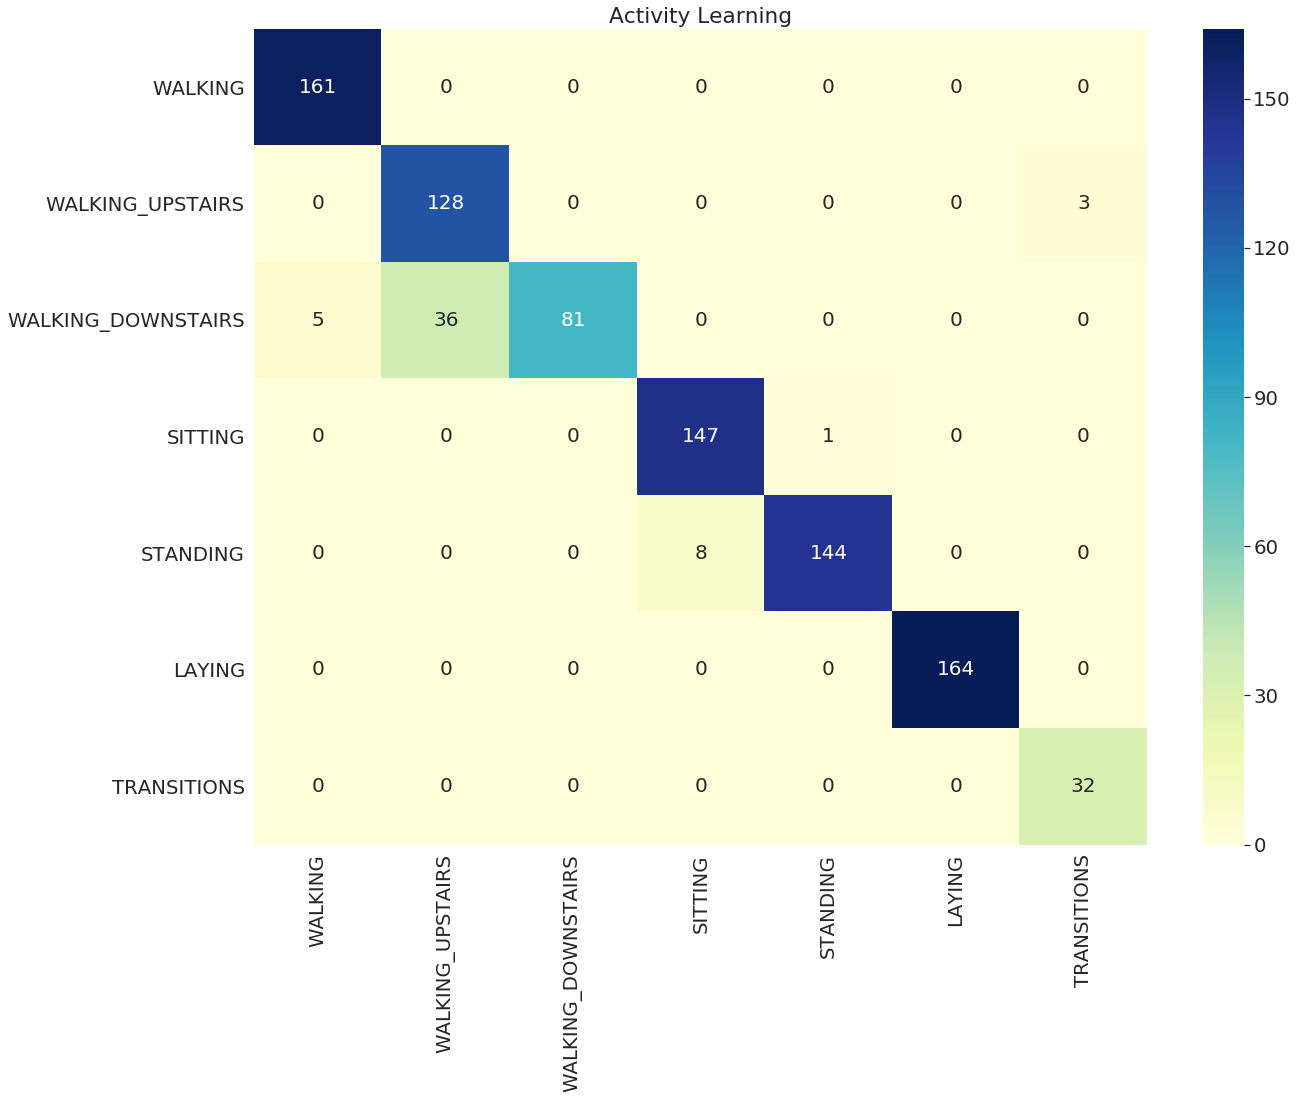

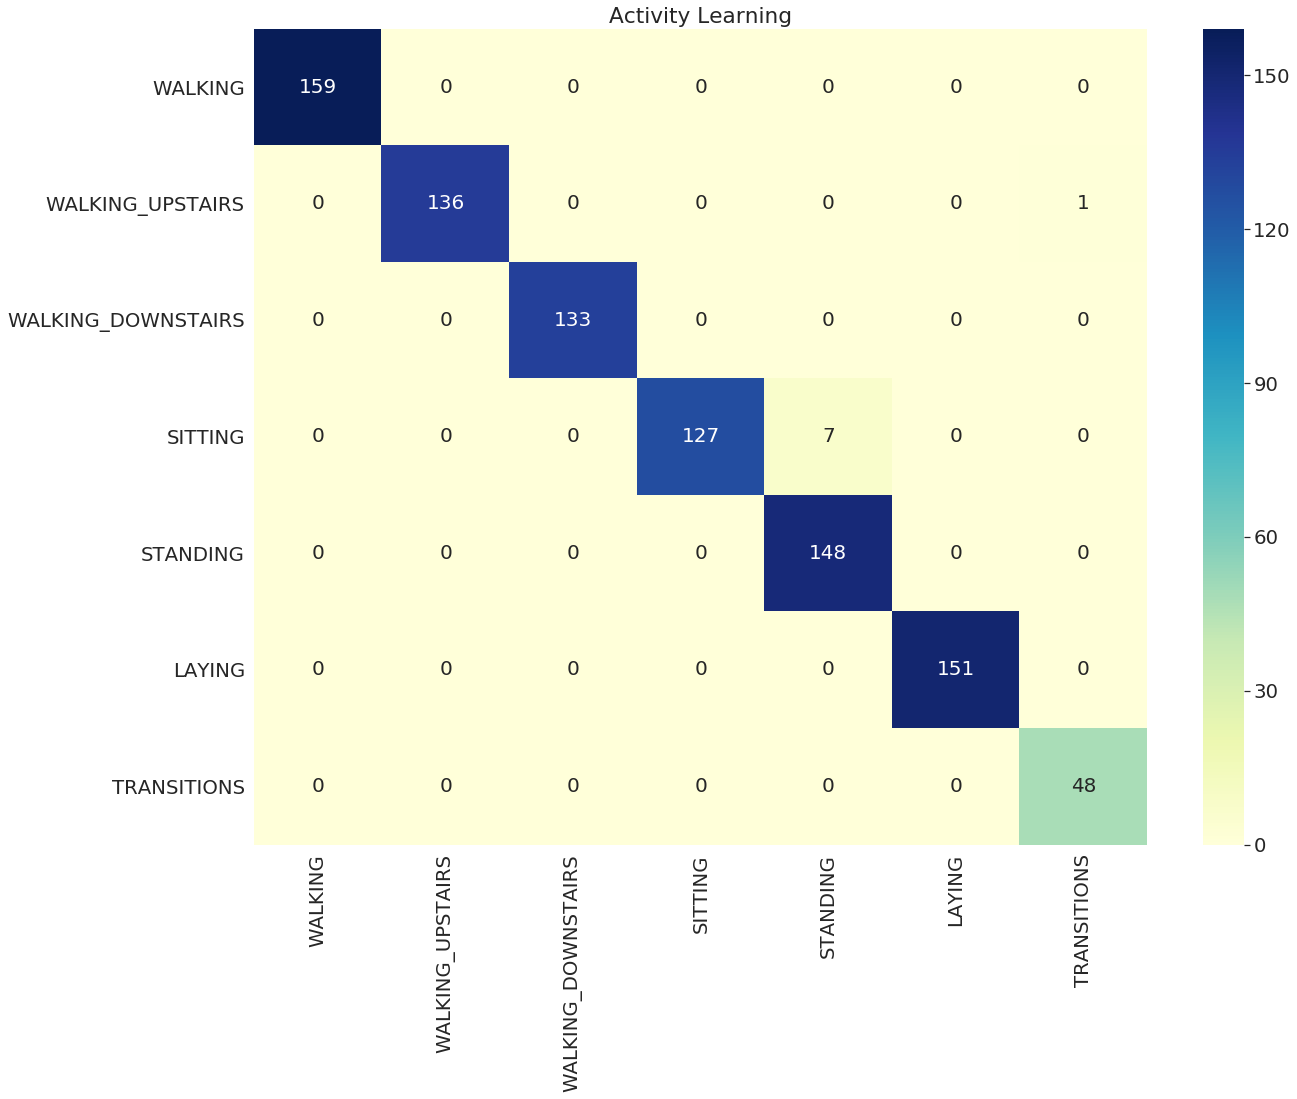

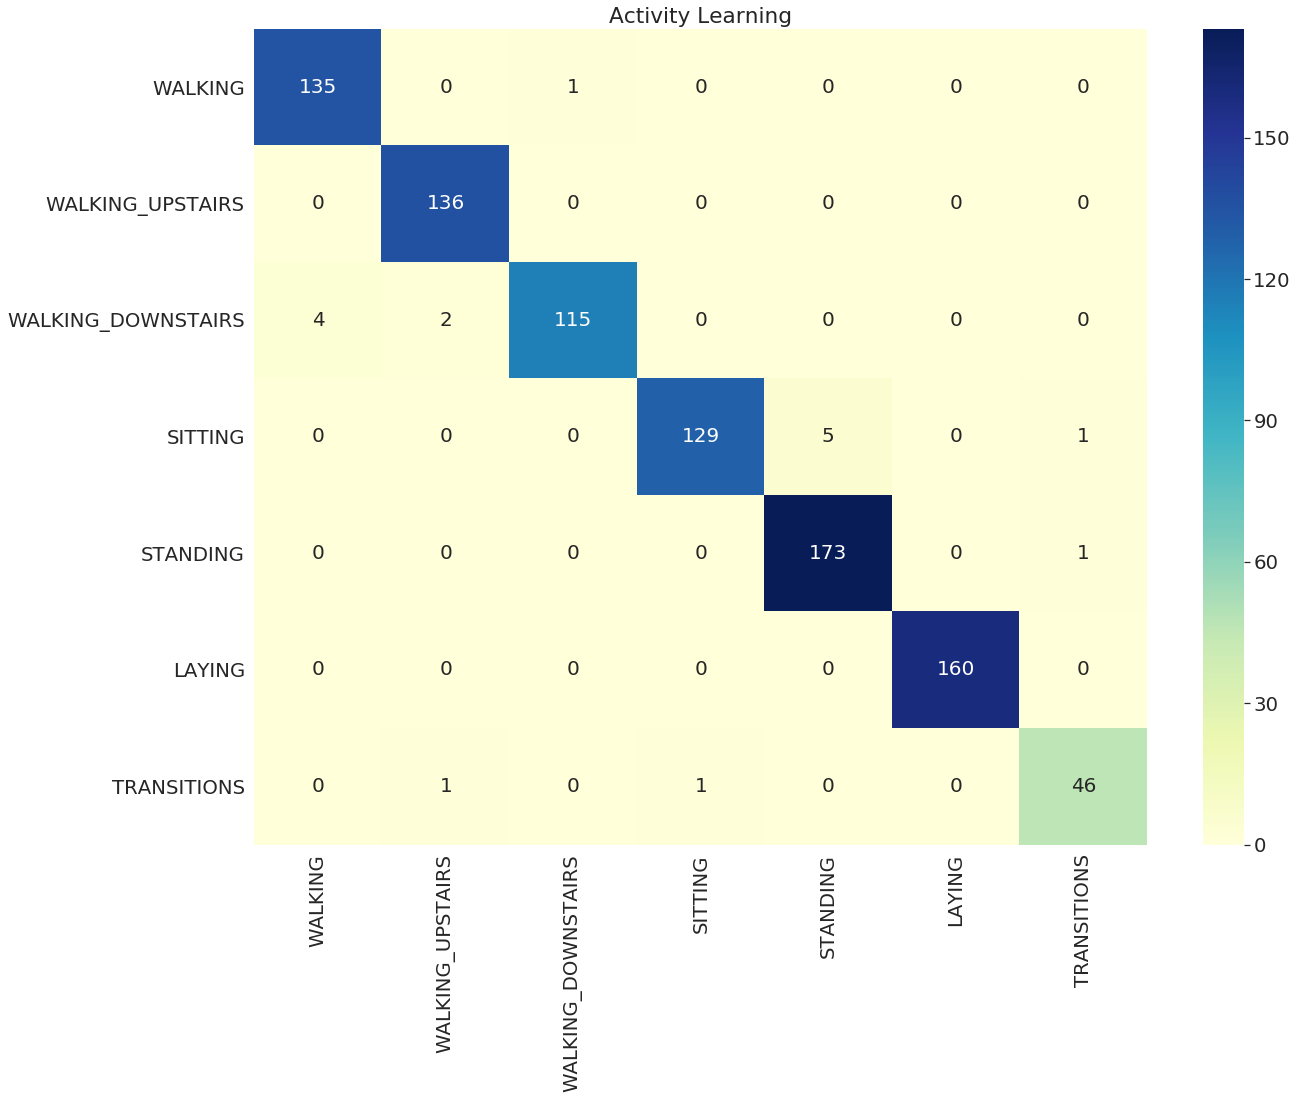

In [22]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index )
    X_train, X_test, X_val = X[train_index], X[test_index[int(len(test_index)*0.5):]], X[test_index[:int(len(test_index)*0.5)]]
    Y_train, Y_test, Y_val = Y[train_index], Y[test_index[int(len(test_index)*0.5):]], Y[test_index[:int(len(test_index)*0.5)]]
    Y_transition_train=np.where(Y_train > 6, Y_train, 0)
    Y_transition_validation=np.where(Y_val > 6, Y_val, 0)
    Y_transition_test=np.where(Y_test > 6, Y_test, 0)
    Y_activities_train=np.where(Y_train < 7, Y_train, 0)
    Y_activities_validation=np.where(Y_val < 7, Y_val, 0)
    Y_activities_test=np.where(Y_test < 7, Y_test, 0)

    train_inp, train_out = X_train, one_hot(Y_activities_train, [1, 2, 3, 4, 5, 6, 0])
    val_inp, val_out = X_val, one_hot(Y_activities_validation, [1, 2, 3, 4, 5, 6, 0])
    test_inp, test_out = X_test, one_hot(Y_activities_test, [1, 2, 3, 4, 5, 6, 0])
    
    train_gru(config, train_inp, train_out, val_inp, val_out)


In [25]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_numpy = pred_t.data.cpu().numpy()
    transition_act=np.where(np.argmax(pred_numpy, axis=1)==6, True, False)
    print(transition_act)
    groups = [(list(v), g) for g,v in itertools.groupby(transition_act)]
    processed=0
    transition_y_hat=[]
    #print(groups)
    for group in groups:
        cont=group[0]
        g=group[1]
        trans_pred=0
        if g:
            if(len(cont)>0):
                prev_act=np.argmax(pred_numpy[processed-1])+1
                next_act=np.argmax(pred_numpy[processed+len(cont)])+1
                if(prev_act==5 and next_act==4):
                    trans_pred=7
                elif(prev_act==5 and next_act==6):
                    trans_pred=11
                elif(prev_act==4 and next_act==5):
                    trans_pred=8
                elif(prev_act==4 and next_act==6):
                    trans_pred=9
                elif(prev_act==6 and next_act==4):
                    trans_pred=10
                elif(prev_act==6 and next_act==5):
                    print("class 12 should be predicted")
                    trans_pred=12
                elif(prev_act==6 and next_act==1):
                    trans_pred=12
                else:
                    print("something broke. Prev{}. Next{}".format(prev_act, next_act))
                processed+=len(cont)
            else:
                processed+=len(cont)
        else:
            processed+=len(cont)
        transition_y_hat.append(np.ones_like(cont)*trans_pred)
    transition_y_hat = np.hstack(transition_y_hat)
    
    pred_one_hot = one_hot(transition_y_hat, [0, 7, 8, 9, 10, 11, 12])
    
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_one_hot, axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate", "Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((transition_label_names, np.vstack(results_metrics)))))
    with open("timesplit_negative_activity_transition_classification_results_BiGRU_paper_comp_2.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
    with open("timesplit_negative_activity_transition_classification_results_BiGRU_paper_comp_2_conf_matrix.csv", 'a') as f:    
        pd.DataFrame(np.hstack((transition_label_names.reshape(-1, 1), results_conf_mat))).to_csv(f, header=False)
    plt.subplots(figsize=(20,15))
    sns.set(font_scale = 1.8)
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=transition_label_names, yticklabels=transition_label_names)
    title="Transition Learning"
    s.set_title(title)

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(1.0736, device='cuda:0'))
(100, tensor(0.8691, device='cuda:0'))
(200, tensor(0.8389, device='cuda:0'))
(300, tensor(0.8286, device='cuda:0'))
(400, tensor(0.8231, device='cuda:0'))
(500, tensor(0.8194, device='cuda:0'))
(600, tensor(0.8168, device='cuda:0'))
(700, tensor(0.8148, device='cuda:0'))
(800, tensor(0.8132, device='cuda:0'))
(900, tensor(0.8119, device='cuda:0'))
(1000, tensor(0.8107, device='cuda:0'))
(1100, tensor(0.8097, device='cuda:0'))
(1200, tensor(0.8088, device='cuda:0'))
(1300, tensor(0.8079, device='cuda:0'))
(1400, tensor(0.8070, device='cuda:0'))
(1500, tensor(0.8063, device='cuda:0'))
(1600, tensor(0.8056, device='cuda:0'))
(1700, tensor(0.8050, device='cuda:0'))
(1800, tensor(0.8045, device='cuda:0'))
(1900, tensor(0.8041, device='cuda:0'))
(2000, tensor(0.8037, device='cuda:0'))
(2100, tensor(0.8034, device='cuda:0'))
(2200, tensor(0.8031, device='cuda:0'))
(2300, tensor(0.8029, device='cuda:0'))
(2400, tensor(0.8028, device='cuda:0'))
(2500, tenso

(800, tensor(0.9177, device='cuda:0'))
(900, tensor(0.9162, device='cuda:0'))
(1000, tensor(0.9149, device='cuda:0'))
(1100, tensor(0.9137, device='cuda:0'))
(1200, tensor(0.9125, device='cuda:0'))
(1300, tensor(0.9114, device='cuda:0'))
(1400, tensor(0.9103, device='cuda:0'))
(1500, tensor(0.9093, device='cuda:0'))
(1600, tensor(0.9083, device='cuda:0'))
(1700, tensor(0.9073, device='cuda:0'))
(1800, tensor(0.9065, device='cuda:0'))
(1900, tensor(0.9057, device='cuda:0'))
(2000, tensor(0.9051, device='cuda:0'))
(2100, tensor(0.9045, device='cuda:0'))
(2200, tensor(0.9040, device='cuda:0'))
(2300, tensor(0.9036, device='cuda:0'))
(2400, tensor(0.9032, device='cuda:0'))
(2500, tensor(0.9028, device='cuda:0'))
(2600, tensor(0.9026, device='cuda:0'))
(2700, tensor(0.9023, device='cuda:0'))
(2800, tensor(0.9021, device='cuda:0'))
(2900, tensor(0.9019, device='cuda:0'))
(3000, tensor(0.9018, device='cuda:0'))
(3100, tensor(0.9016, device='cuda:0'))
(3200, tensor(0.9015, device='cuda:0'))
(3

(2400, tensor(0.9630, device='cuda:0'))
(2500, tensor(0.9626, device='cuda:0'))
(2600, tensor(0.9622, device='cuda:0'))
(2700, tensor(0.9619, device='cuda:0'))
(2800, tensor(0.9616, device='cuda:0'))
(2900, tensor(0.9613, device='cuda:0'))
(3000, tensor(0.9611, device='cuda:0'))
(3100, tensor(0.9609, device='cuda:0'))
(3200, tensor(0.9608, device='cuda:0'))
(3300, tensor(0.9606, device='cuda:0'))
(3400, tensor(0.9605, device='cuda:0'))
(3500, tensor(0.9604, device='cuda:0'))
(3600, tensor(0.9603, device='cuda:0'))
(3700, tensor(0.9602, device='cuda:0'))
(3800, tensor(0.9601, device='cuda:0'))
(3900, tensor(0.9600, device='cuda:0'))
(4000, tensor(0.9600, device='cuda:0'))
(4100, tensor(0.9599, device='cuda:0'))
(4200, tensor(0.9599, device='cuda:0'))
(4300, tensor(0.9599, device='cuda:0'))
(4400, tensor(0.9598, device='cuda:0'))
(4500, tensor(0.9598, device='cuda:0'))
(4600, tensor(0.9598, device='cuda:0'))
(4700, tensor(0.9597, device='cuda:0'))
(4800, tensor(0.9597, device='cuda:0'))


(3900, tensor(1.0021, device='cuda:0'))
(4000, tensor(1.0020, device='cuda:0'))
(4100, tensor(1.0019, device='cuda:0'))
(4200, tensor(1.0019, device='cuda:0'))
(4300, tensor(1.0018, device='cuda:0'))
(4400, tensor(1.0017, device='cuda:0'))
(4500, tensor(1.0017, device='cuda:0'))
(4600, tensor(1.0016, device='cuda:0'))
(4700, tensor(1.0016, device='cuda:0'))
(4800, tensor(1.0016, device='cuda:0'))
(4900, tensor(1.0015, device='cuda:0'))
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False 

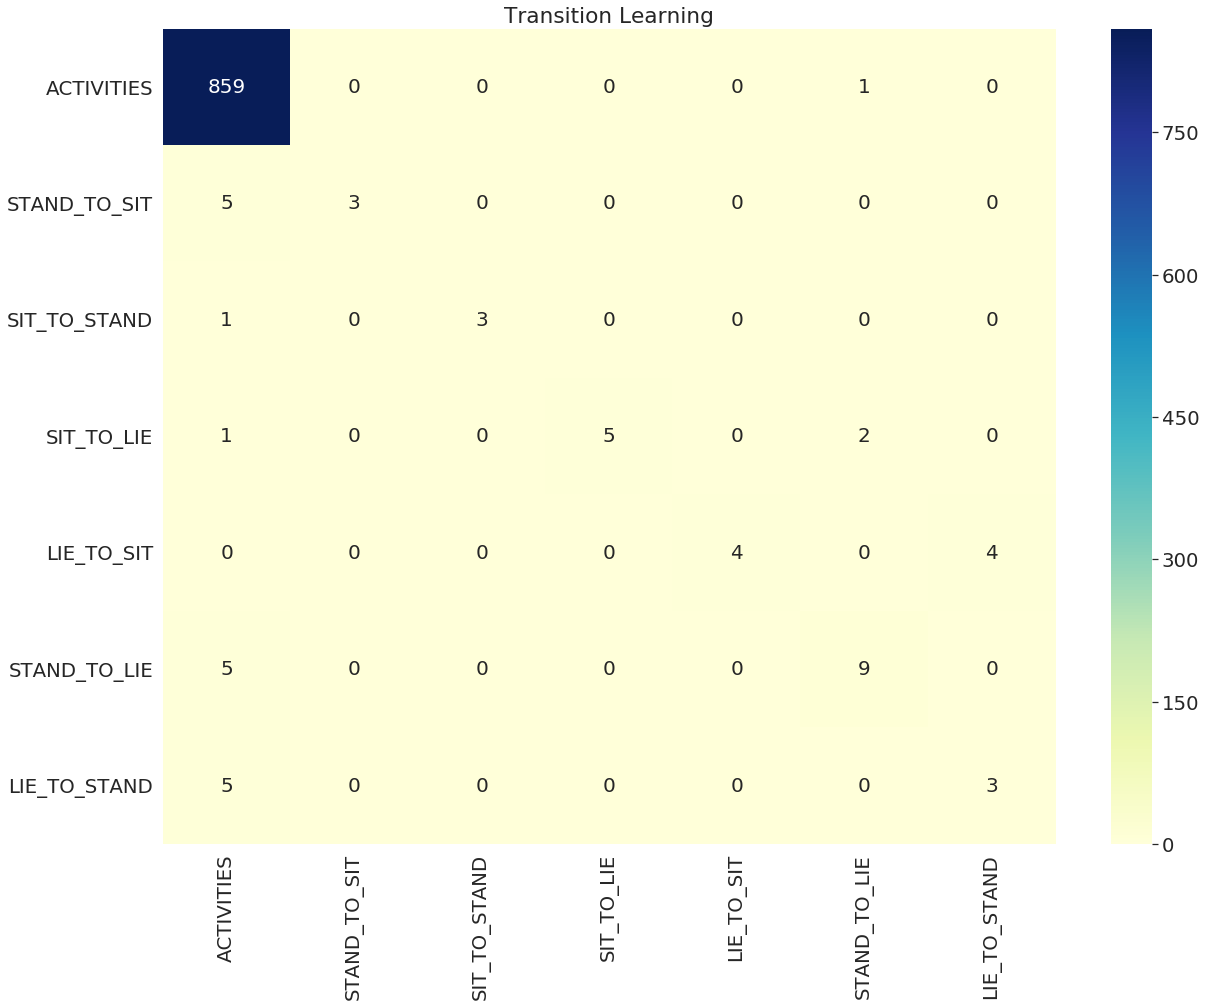

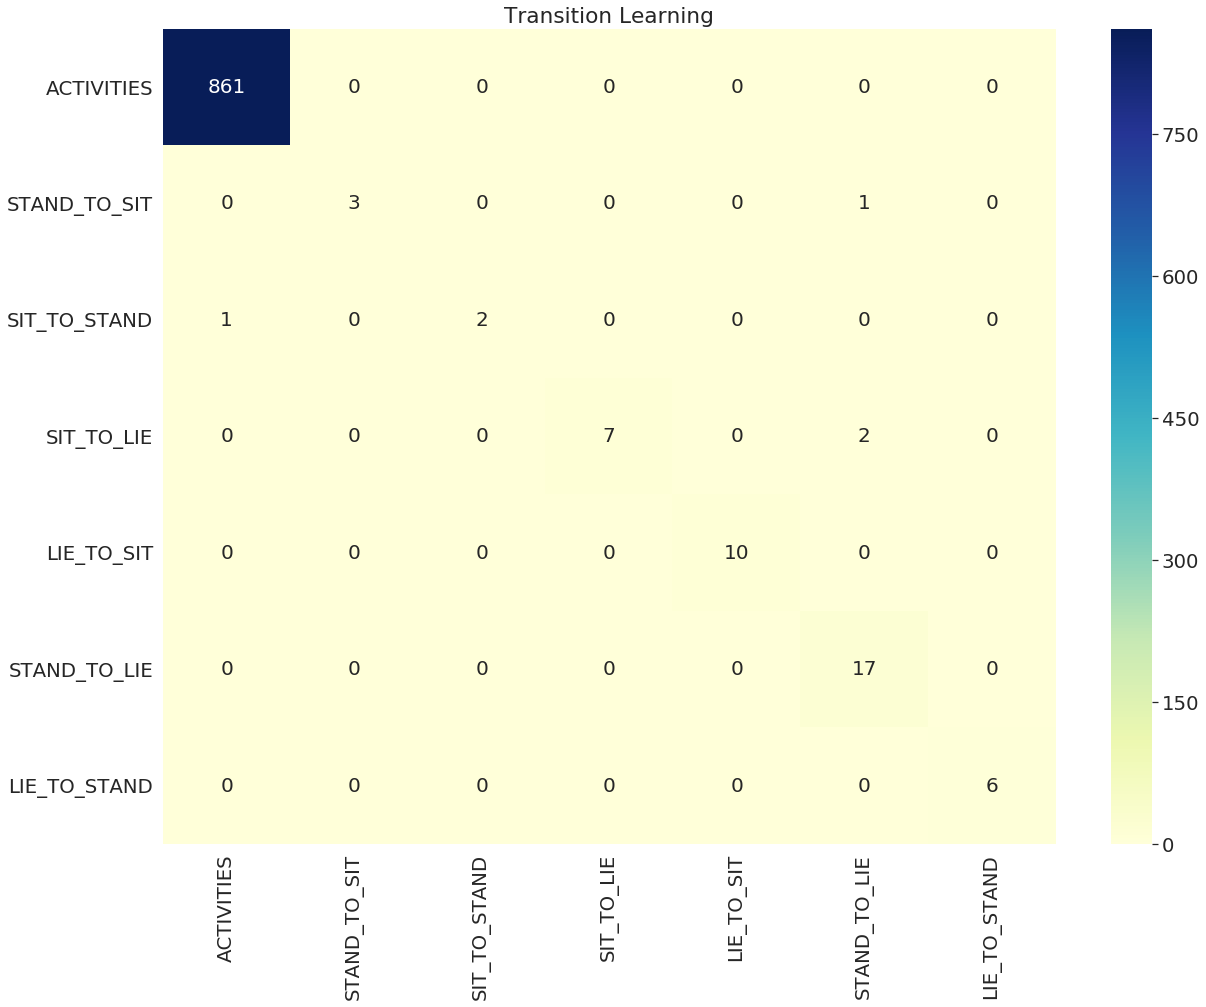

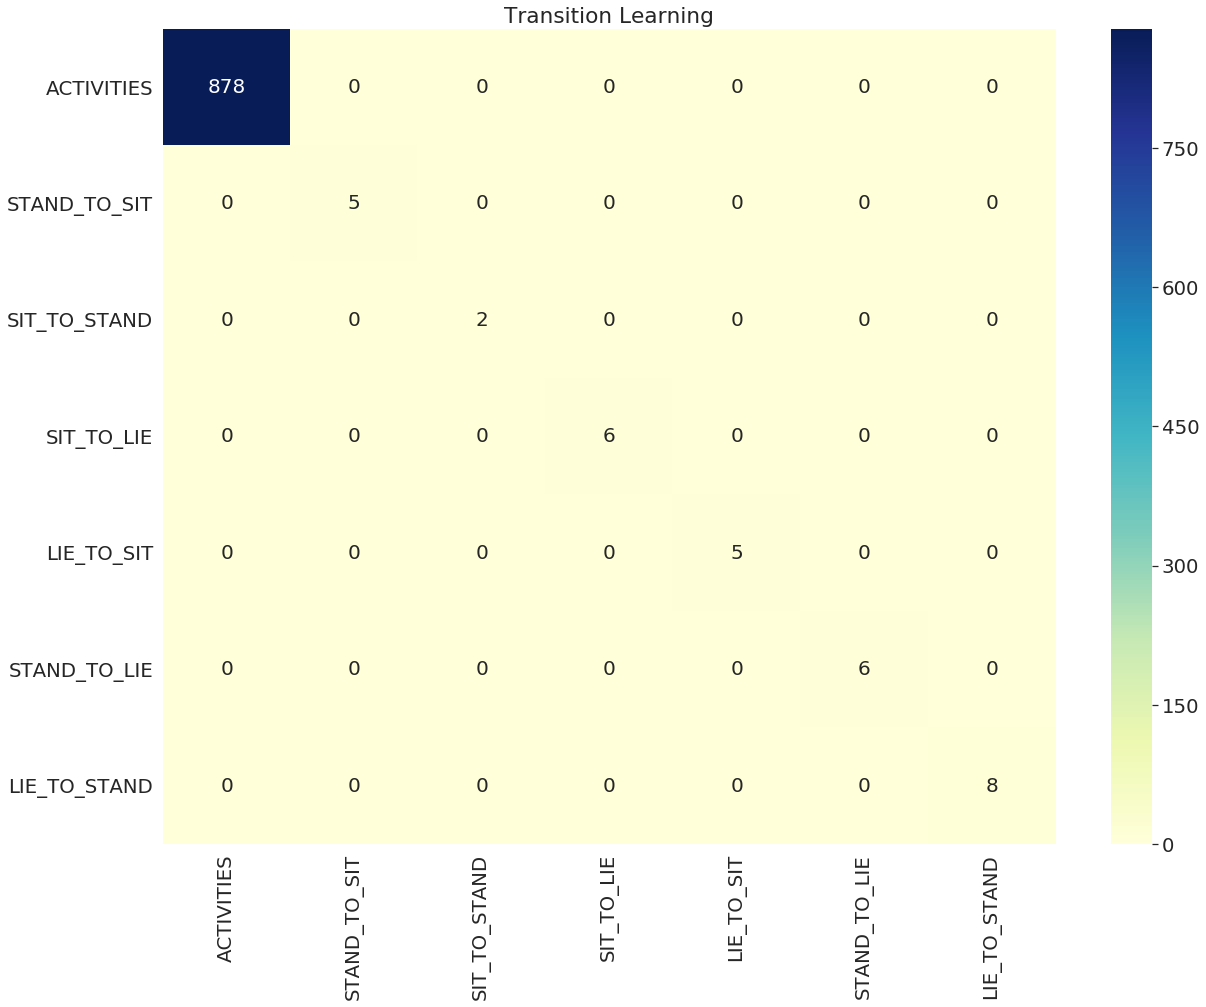

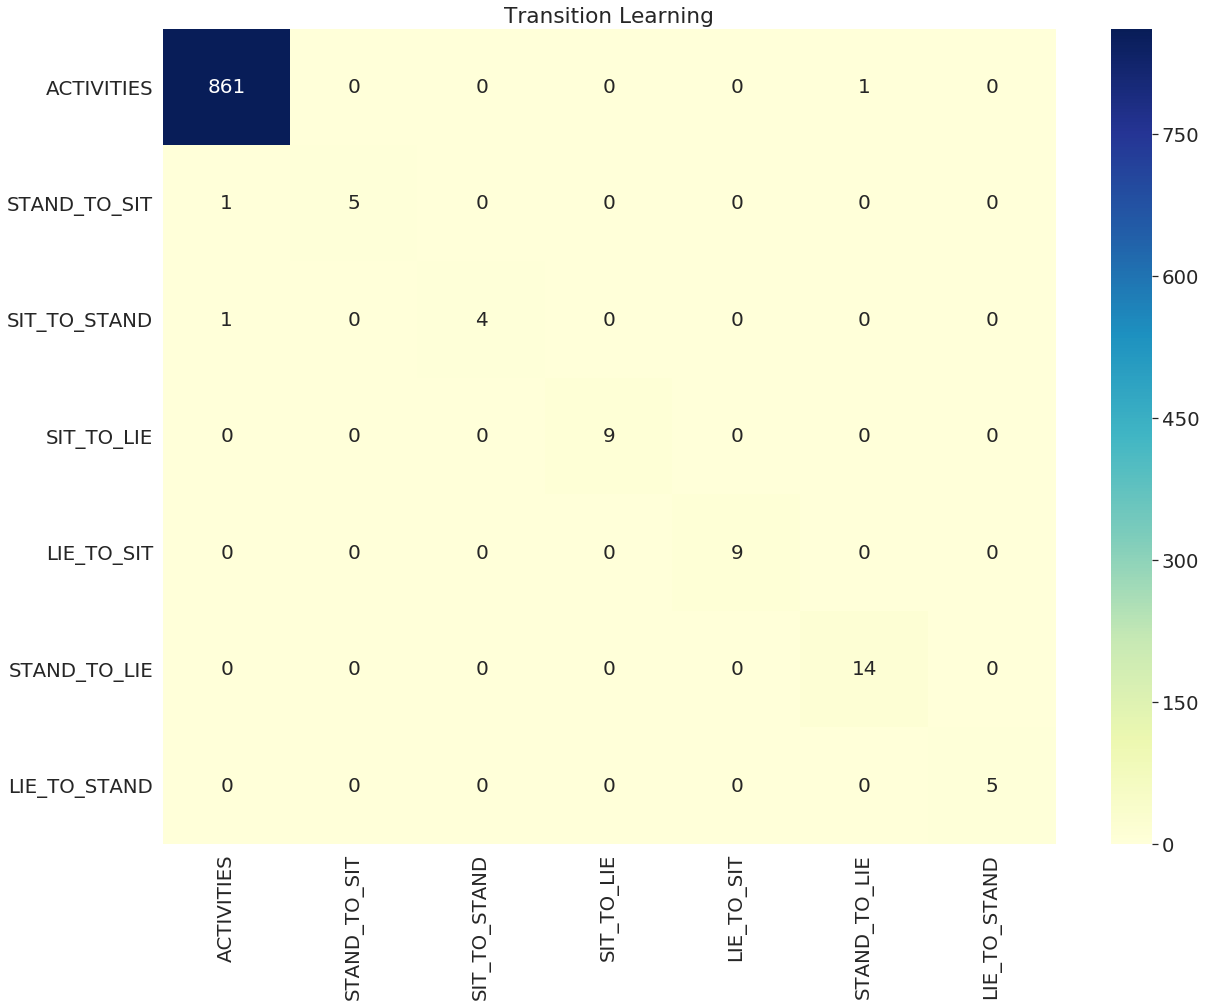

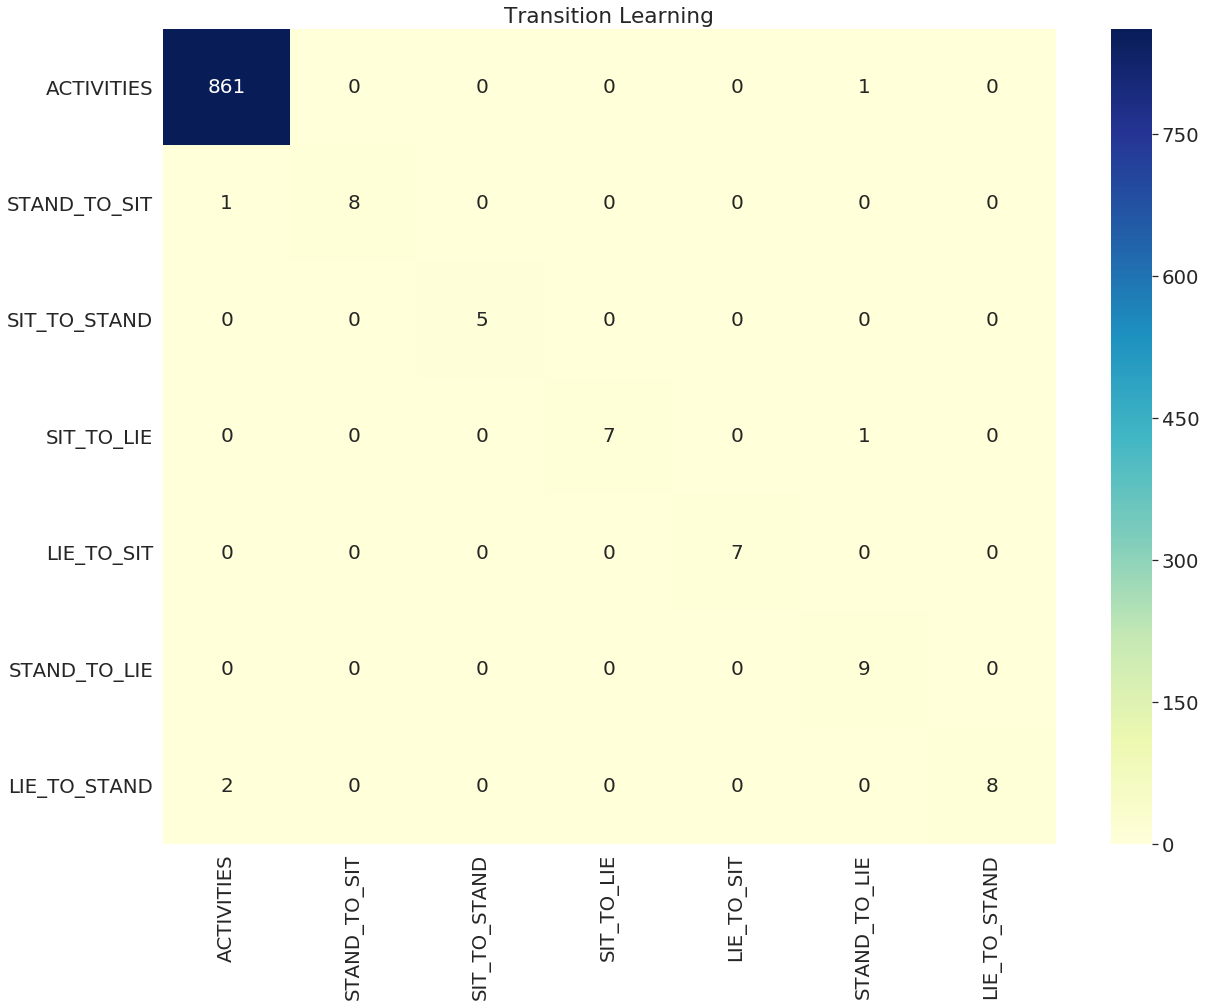

In [26]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index )
    X_train, X_test, X_val = X[train_index], X[test_index[int(len(test_index)*0.5):]], X[test_index[:int(len(test_index)*0.5)]]
    Y_train, Y_test, Y_val = Y[train_index], Y[test_index[int(len(test_index)*0.5):]], Y[test_index[:int(len(test_index)*0.5)]]
    Y_transition_train=np.where(Y_train > 6, Y_train, 0)
    Y_transition_validation=np.where(Y_val > 6, Y_val, 0)
    Y_transition_test=np.where(Y_test > 6, Y_test, 0)
    Y_activities_train=np.where(Y_train < 7, Y_train, 0)
    Y_activities_validation=np.where(Y_val < 7, Y_val, 0)
    Y_activities_test=np.where(Y_test < 7, Y_test, 0)

    train_act_inp, train_act_out = X_train, one_hot(Y_activities_train, [1, 2, 3, 4, 5, 6, 0])
    val_act_inp, val_act_out = X_val, one_hot(Y_activities_validation, [1, 2, 3, 4, 5, 6, 0])
    test_act_inp, test_act_out = X_test, one_hot(Y_activities_test, [1, 2, 3, 4, 5, 6, 0])
    
    train_trans_inp, train_trans_out = X_train, one_hot(Y_transition_train, [0,7,8,9,10,11,12])
    val_trans_inp, val_trans_out = X_val, one_hot(Y_transition_validation, [0,7,8,9,10,11,12])
    test_trans_inp, test_trans_out = X_test, one_hot(Y_transition_test, [0,7,8,9,10,11,12])

    train_gru(config, train_act_inp, train_act_out, val_act_inp, val_trans_out)


In [33]:
def train_gru(config, train_inp, train_out, test_inp, test_out):
    r= CustomRNN(config["input_dim"], config["hidden_size"], config["output_dim"]).to(device)
    predictions = []
    optimizer = torch.optim.Adam(r.parameters(), lr=config["learning_rate"])
    #loss_func = nn.L1Loss()
    loss_func = F.binary_cross_entropy

    for t in range(config["num_epochs"]):
        hidden = None
        inp = Variable(torch.from_numpy(train_inp.reshape((train_inp.shape[0], -1, config["input_dim"]))).type(dtype), requires_grad=True)
        out = Variable(torch.from_numpy(train_out.reshape((train_inp.shape[0], config["output_dim"]))).type(dtype))
    
        pred = r(inp)
        optimizer.zero_grad()
        predictions.append(pred.data.cpu().numpy())
        loss = loss_func(pred, out)
        if t%100==0:
            print(t, loss.data[0])
        loss.backward()
        optimizer.step()
        
    t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 561))).type(dtype), requires_grad=True)
    pred_t = r(t_inp)
    pred_one_hot = one_hot(np.argmax(pred_t.data.cpu().numpy(), axis=1)+1, range(1, len(label_names)+1))
    results_metrics = get_metrics(test_out, pred_one_hot)
    results_conf_mat = confusion_matrix(np.argmax(test_out, axis=1)+1, np.argmax(pred_t.data.cpu().numpy(), axis=1)+1)
    metric_names = np.array(["CV", "Balanced Accuracy", "Accuracy", "Error Rate","Precision","Recall","Specificity", "F1", "TP","FP","FN","TN", "Micro F1","Macro F1","Weighted F1","Log-Loss","ROC AUC"])
    results = np.hstack((metric_names.reshape(-1, 1), np.vstack((label_names, np.vstack(results_metrics)))))
    with open("timesplit_BiGRU_Baseline_all_5000_w_validation.csv", 'a') as f:
        pd.DataFrame(results).to_csv(f, header=False)
             
    plt.subplots(figsize=(20,15))
    s=sns.heatmap(results_conf_mat.astype(int), annot=True, annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=label_names, yticklabels=label_names)
    title="Activity Transition Learning"
    s.set_title(title)
    

In [34]:
config = {}
config["input_dim"] = 561
config["hidden_size"] = 512
config["num_layers"] = 4
config["output_dim"] = 12
config["num_epochs"] = 5000
config["learning_rate"] = 1e-4

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, tensor(0.6233, device='cuda:0'))
(100, tensor(0.5050, device='cuda:0'))
(200, tensor(0.4851, device='cuda:0'))
(300, tensor(0.4780, device='cuda:0'))
(400, tensor(0.4740, device='cuda:0'))
(500, tensor(0.4714, device='cuda:0'))
(600, tensor(0.4697, device='cuda:0'))
(700, tensor(0.4684, device='cuda:0'))
(800, tensor(0.4674, device='cuda:0'))
(900, tensor(0.4665, device='cuda:0'))
(1000, tensor(0.4658, device='cuda:0'))
(1100, tensor(0.4651, device='cuda:0'))
(1200, tensor(0.4645, device='cuda:0'))
(1300, tensor(0.4640, device='cuda:0'))
(1400, tensor(0.4635, device='cuda:0'))
(1500, tensor(0.4631, device='cuda:0'))
(1600, tensor(0.4627, device='cuda:0'))
(1700, tensor(0.4624, device='cuda:0'))
(1800, tensor(0.4621, device='cuda:0'))
(1900, tensor(0.4619, device='cuda:0'))
(2000, tensor(0.4617, device='cuda:0'))
(2100, tensor(0.4615, device='cuda:0'))
(2200, tensor(0.4614, device='cuda:0'))
(2300, tensor(0.4613, device='cuda:0'))
(2400, tensor(0.4612, device='cuda:0'))
(2500, tenso

(700, tensor(0.6105, device='cuda:0'))
(800, tensor(0.6094, device='cuda:0'))
(900, tensor(0.6084, device='cuda:0'))
(1000, tensor(0.6075, device='cuda:0'))
(1100, tensor(0.6066, device='cuda:0'))
(1200, tensor(0.6058, device='cuda:0'))
(1300, tensor(0.6050, device='cuda:0'))
(1400, tensor(0.6043, device='cuda:0'))
(1500, tensor(0.6036, device='cuda:0'))
(1600, tensor(0.6029, device='cuda:0'))
(1700, tensor(0.6023, device='cuda:0'))
(1800, tensor(0.6017, device='cuda:0'))
(1900, tensor(0.6011, device='cuda:0'))
(2000, tensor(0.6006, device='cuda:0'))
(2100, tensor(0.6002, device='cuda:0'))
(2200, tensor(0.5998, device='cuda:0'))
(2300, tensor(0.5994, device='cuda:0'))
(2400, tensor(0.5991, device='cuda:0'))
(2500, tensor(0.5988, device='cuda:0'))
(2600, tensor(0.5985, device='cuda:0'))
(2700, tensor(0.5982, device='cuda:0'))
(2800, tensor(0.5980, device='cuda:0'))
(2900, tensor(0.5978, device='cuda:0'))
(3000, tensor(0.5976, device='cuda:0'))
(3100, tensor(0.5975, device='cuda:0'))
(32

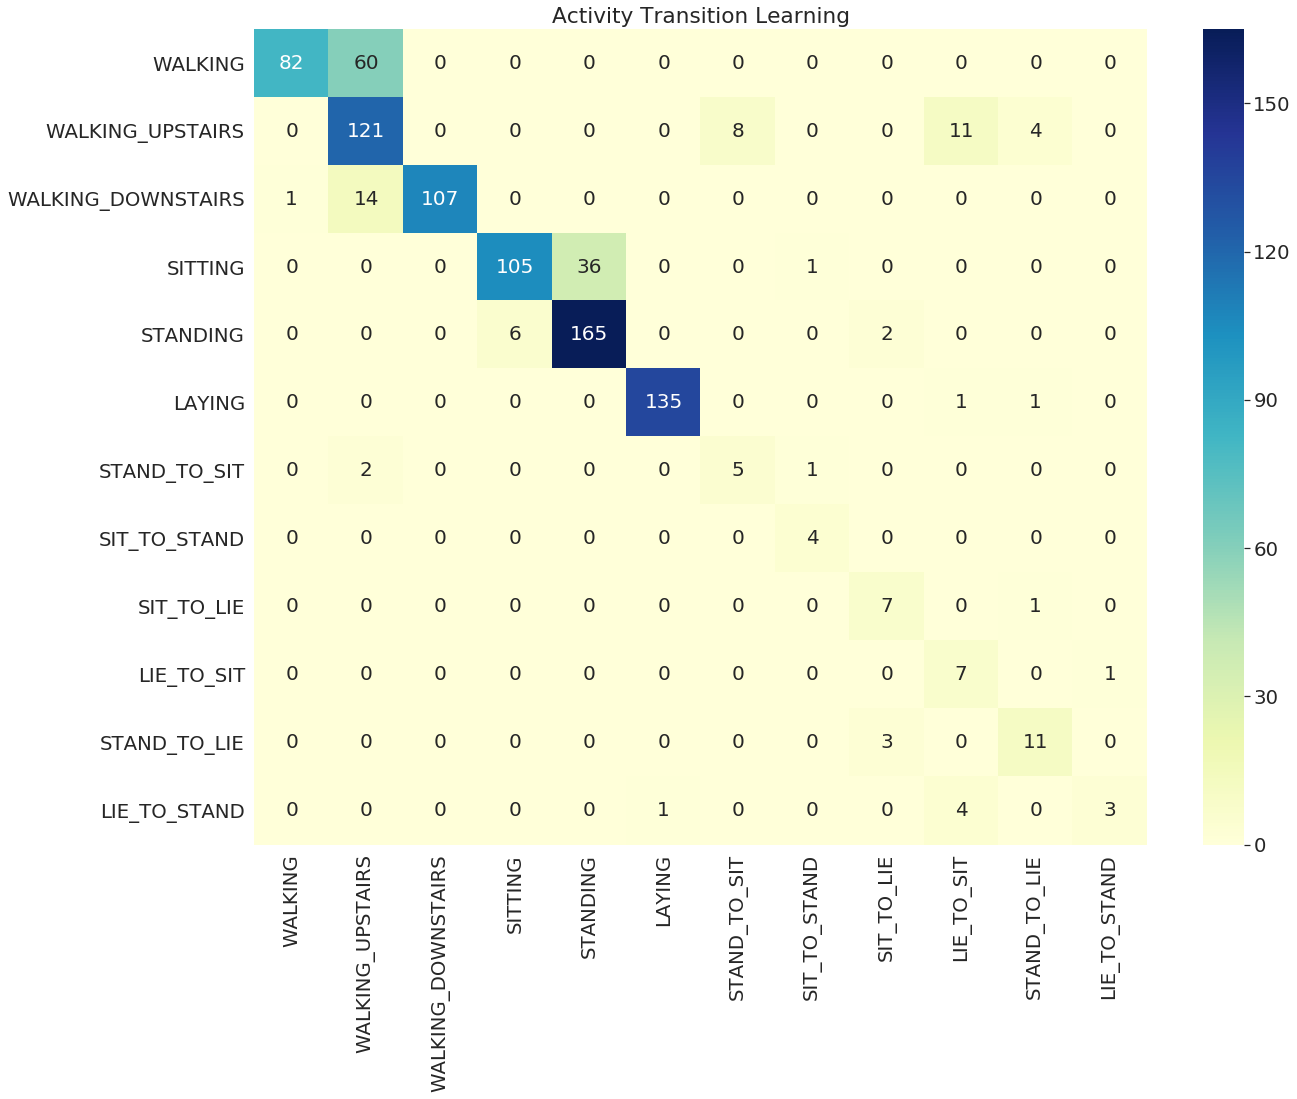

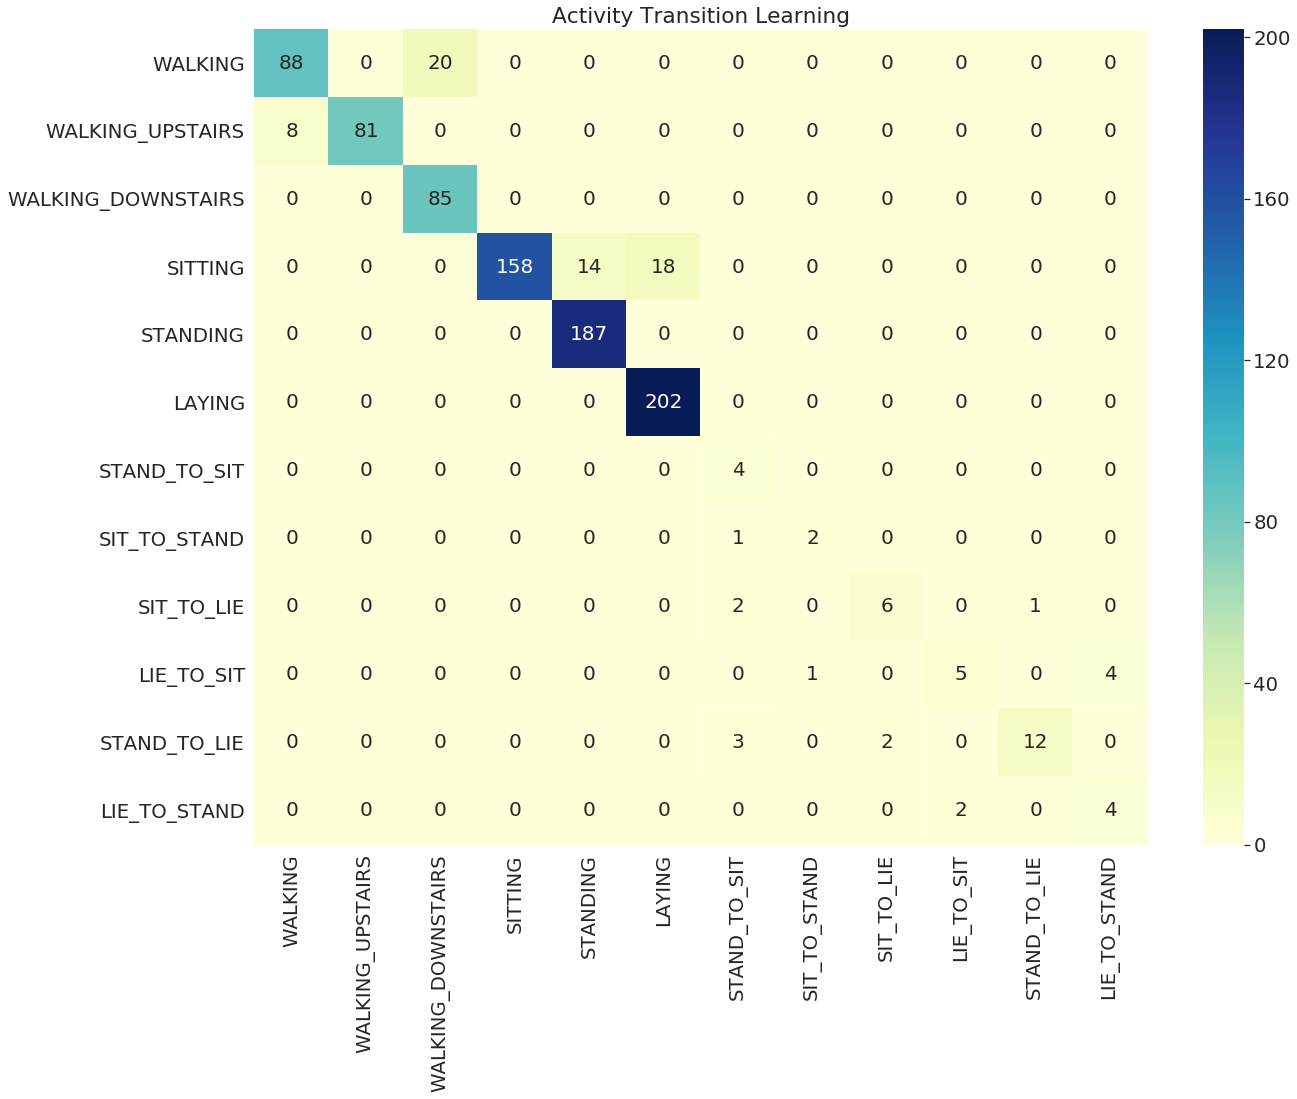

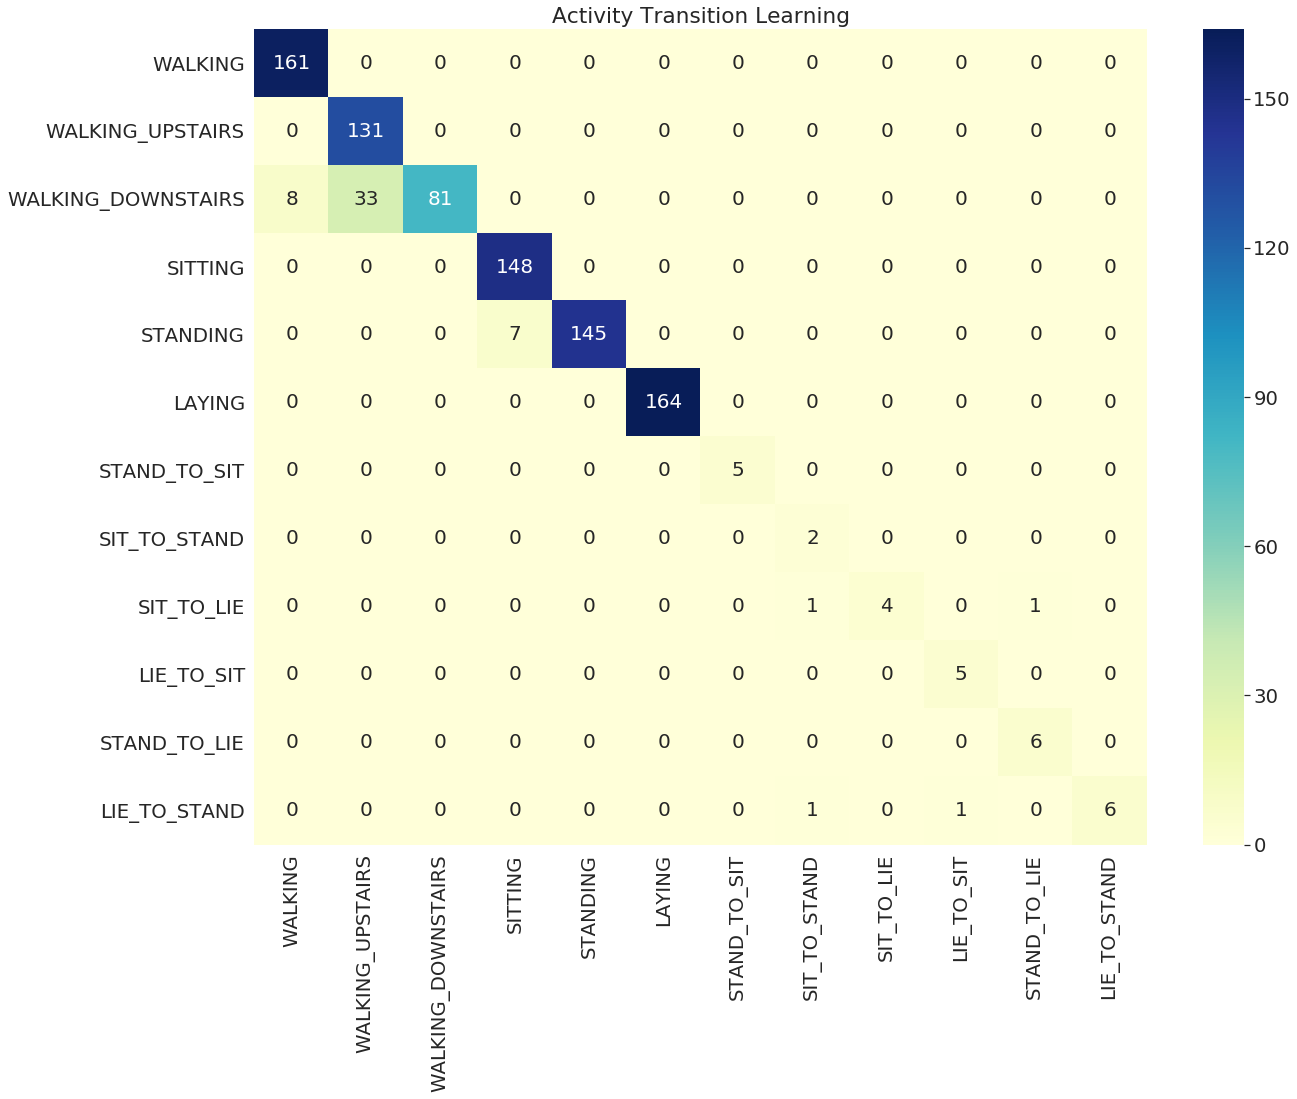

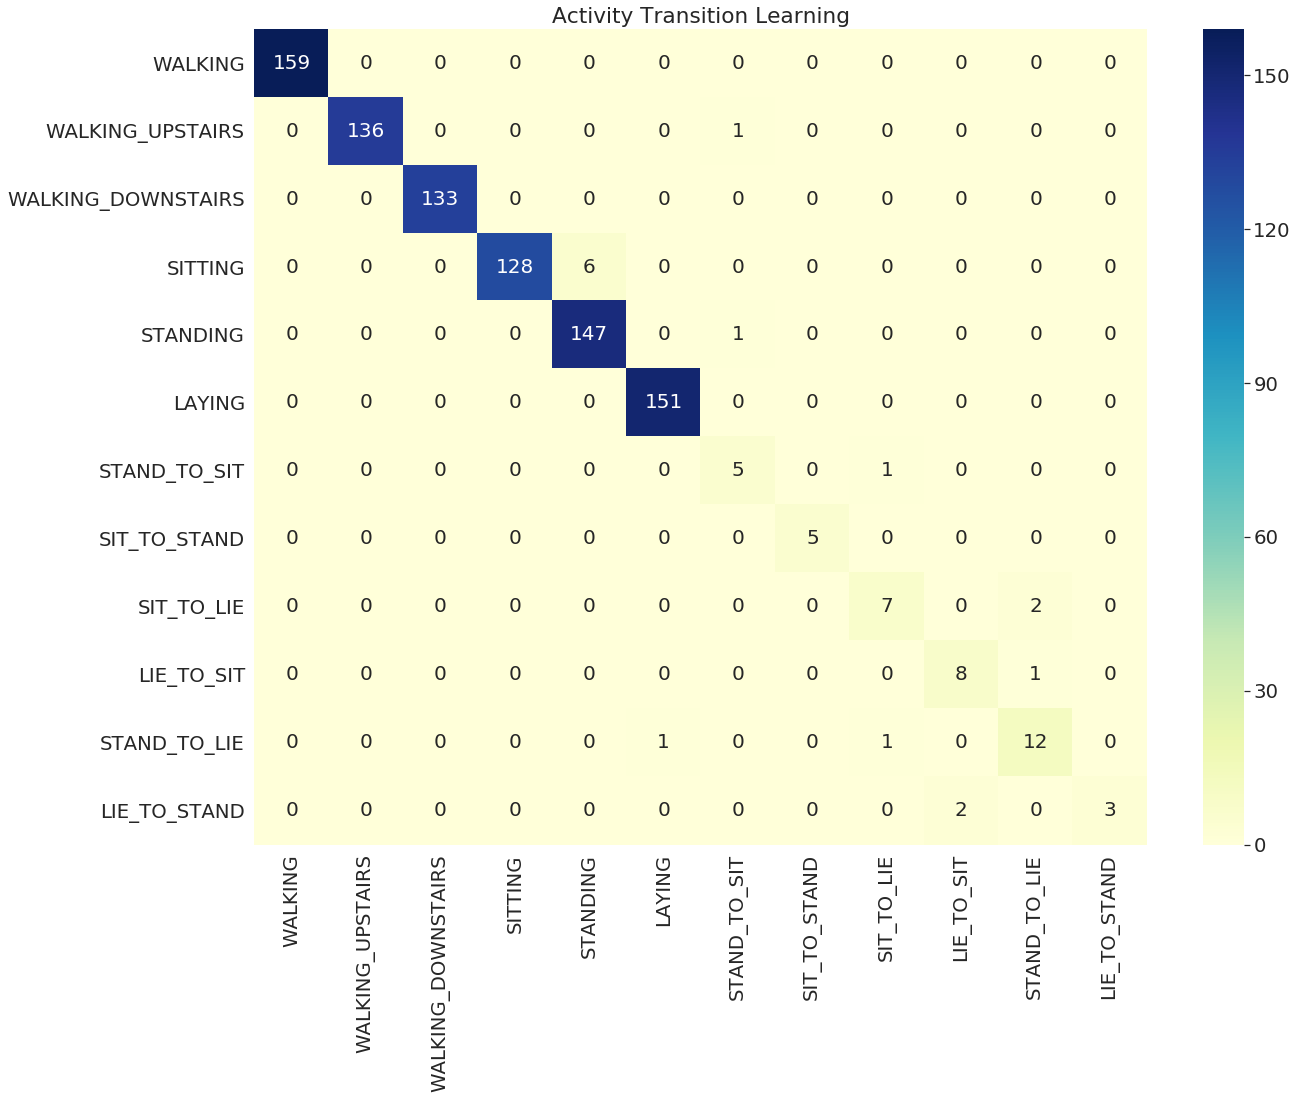

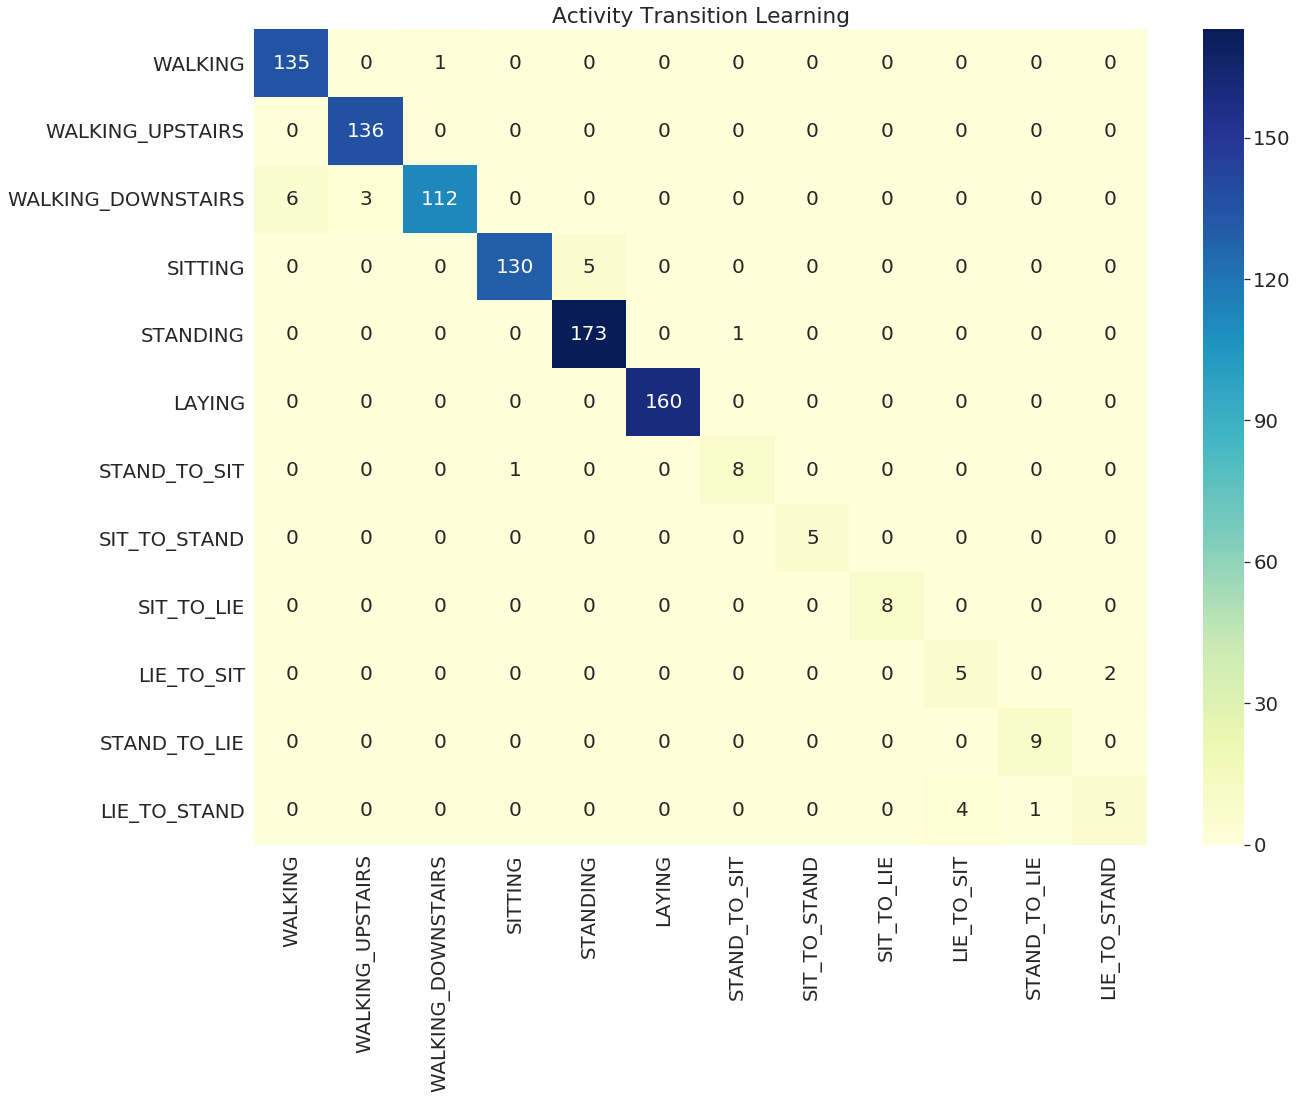

In [35]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index )
    X_train, X_test, X_val = X[train_index], X[test_index[int(len(test_index)*0.5):]], X[test_index[:int(len(test_index)*0.5)]]
    Y_train, Y_test, Y_val = Y[train_index], Y[test_index[int(len(test_index)*0.5):]], Y[test_index[:int(len(test_index)*0.5)]]
    
    train_inp, train_out = X_train, one_hot(Y_train, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    val_inp, val_out = X_val, one_hot(Y_val, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    test_inp, test_out = X_test, one_hot(Y_test, [1, 2, 3, 4, 5, 6, 7,8,9,10,11,12])
    
    train_gru(config, train_inp, train_out, val_inp, val_out)

